Connected to MetaTrader 5


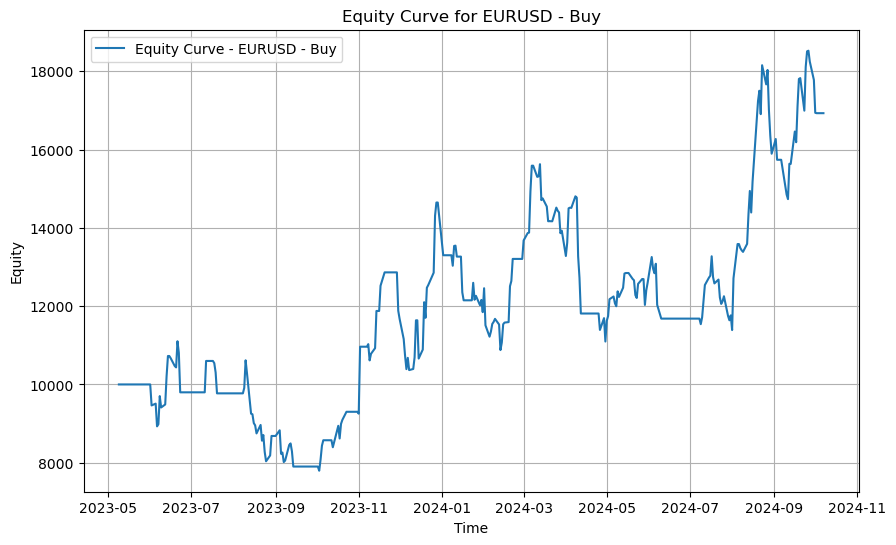

Backtest results for EURUSD - Buy:
 Start                     2023-05-09 00:00:00
End                       2024-10-07 00:00:00
Duration                    517 days 00:00:00
Exposure Time [%]                        62.5
Equity Final [$]                 16930.918678
Equity Peak [$]                  18526.683149
Return [%]                          69.309187
Buy & Hold Return [%]                 0.11586
Return (Ann.) [%]                   43.415617
Volatility (Ann.) [%]                80.81693
Sharpe Ratio                         0.537209
Sortino Ratio                        1.308285
Calmar Ratio                         1.457195
Max. Drawdown [%]                  -29.793961
Avg. Drawdown [%]                  -15.005645
Max. Drawdown Duration      159 days 00:00:00
Avg. Drawdown Duration       47 days 00:00:00
# Trades                                   63
Win Rate [%]                        57.142857
Best Trade [%]                         0.8825
Worst Trade [%]                     -0.91950

In [2]:
import pandas as pd
import MetaTrader5 as mt5
from backtesting import Backtest, Strategy
import logging
from datetime import datetime
import pytz
import matplotlib.pyplot as plt

# Logging configuration
logging.basicConfig(filename='backtest.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# MetaTrader 5 initialization
def init_mt5_connection(login, password, server):
    if not mt5.initialize(login=login, password=password, server=server):
        logging.error(f"initialize() failed, error code = {mt5.last_error()}")
        sys.exit()
    logging.info("Connected to MetaTrader 5")
    print("Connected to MetaTrader 5")

# Fetch historical OHLC data from MetaTrader 5
def fetch_ohlc_data(symbol, timeframe, start_date, end_date):
    data = mt5.copy_rates_range(symbol, timeframe, start_date, end_date)
    if data is None or len(data) == 0:
        logging.error(f"Failed to fetch data for {symbol}")
        return None
    ohlc_data = pd.DataFrame(data)
    ohlc_data['time'] = pd.to_datetime(ohlc_data['time'], unit='s')
    ohlc_data.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'tick_volume': 'Volume'}, inplace=True)
    return ohlc_data[['time', 'Open', 'High', 'Low', 'Close', 'Volume']]  # Include Volume

# Load and align prediction data
def load_and_align_data(ohlc_data, prediction_file):
    try:
        predictions = pd.read_csv(prediction_file, parse_dates=['time'])
        if 'prediction' not in predictions.columns:
            logging.error(f"'prediction' column not found in {prediction_file}")
            return None
    except Exception as e:
        logging.error(f"Error loading prediction file: {e}")
        return None
    # Merge predictions with OHLC data
    ohlc_data = ohlc_data.merge(predictions[['time', 'prediction']], on='time', how='left')
    ohlc_data['prediction'] = ohlc_data['prediction'].fillna(0)  # Fill missing predictions with 0
    ohlc_data['prediction'] = ohlc_data['prediction'].shift(1)  # Shift predictions to next date
    return ohlc_data

# Backtesting strategy for Buy or Sell
class PredictionStrategy(Strategy):
    risk_reward_ratio = (2, 3)  # Default risk-reward ratio
    signal_type = 'Buy'  # Default signal type
    mean_candle_size = 0.0105  # Default mean candle size

    def init(self):
        # Mean candle size now taken from strategy properties set during strategy initialization
        pass

    def next(self):
        entry_price = self.data.Close[-1]
        risk_part, reward_part = self.risk_reward_ratio
        # Buy signal
        if self.data.prediction[-1] == 1 and self.signal_type == 'Buy':
            sl_price = entry_price - self.mean_candle_size * risk_part
            tp_price = entry_price + self.mean_candle_size * reward_part
            self.buy(sl=sl_price, tp=tp_price)
        # Sell signal
        elif self.data.prediction[-1] == 1 and self.signal_type == 'Sell':
            sl_price = entry_price + self.mean_candle_size * risk_part
            tp_price = entry_price - self.mean_candle_size * reward_part
            self.sell(sl=sl_price, tp=tp_price)

""" # Function to perform backtesting and save stats/plot
def run_backtest(ohlc_data, strategy_class, risk_reward_ratio, pair_name, signal_type, mean_candle_size):
    strategy_class.risk_reward_ratio = risk_reward_ratio
    strategy_class.signal_type = signal_type
    strategy_class.mean_candle_size = mean_candle_size  # Set mean candle size for the strategy
    bt = Backtest(ohlc_data.set_index('time'), strategy_class, cash=10000, commission=.0003,margin=.1)
    stats = bt.run()
    plt.figure(figsize=(10, 6))
    bt.plot()
    plt.title(f'Backtest for {pair_name} - {signal_type}')
    #plt.savefig(f'backtest_plot_{pair_name}_{signal_type}.png')
    plt.close()
    stats_df = pd.DataFrame([stats])
    #stats_df.to_csv(f'backtest_stats_{pair_name}_{signal_type}.csv', index=False)
    return stats """

# Function to perform backtesting and save stats/plot
def run_backtest(ohlc_data, strategy_class, risk_reward_ratio, pair_name, signal_type, mean_candle_size):
    strategy_class.risk_reward_ratio = risk_reward_ratio
    strategy_class.signal_type = signal_type
    strategy_class.mean_candle_size = mean_candle_size  # Set mean candle size for the strategy
    
    # Run the backtest
    bt = Backtest(ohlc_data.set_index('time'), strategy_class, cash=10000, commission=.0003, margin=.1)
    stats = bt.run()
    
    # Plot the equity curve
    equity_curve = stats['_equity_curve']['Equity']
    
    plt.figure(figsize=(10, 6))
    plt.plot(equity_curve, label=f'Equity Curve - {pair_name} - {signal_type}')
    plt.title(f'Equity Curve for {pair_name} - {signal_type}')
    plt.xlabel('Time')
    plt.ylabel('Equity')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return stats

# Main function to fetch OHLC data, align it with prediction data, and run backtest for each buy/sell
def main():
    config = {
        'login': 51988090,
        'password': '1fMdV52$74EOcw',
        'server': 'ICMarketsEU-Demo',
        'EURUSD': {
            'symbol': 'EURUSD',
            'timeframe': mt5.TIMEFRAME_D1,
            'mean_candle_size': 0.009196304524519085,
            'buy_prediction_file': 'predEURUSD_D1_3112buy.csv',
            'buy_risk_reward_ratio': (1, 1),
        }
    }

    init_mt5_connection(config['login'], config['password'], config['server'])
    utc_from = datetime(2023, 5, 9, tzinfo=pytz.utc)
    utc_to = datetime(2024, 10, 7, tzinfo=pytz.utc)

    for pair_name, pair_config in config.items():
        if pair_name in ['login', 'password', 'server']:
            continue
        logging.info(f"Processing {pair_name}...")
        ohlc_data = fetch_ohlc_data(pair_config['symbol'], pair_config['timeframe'], utc_from, utc_to)
        if ohlc_data is None:
            continue

        if pair_config['buy_prediction_file']:
            ohlc_data_with_predictions = load_and_align_data(ohlc_data, pair_config['buy_prediction_file'])
            if ohlc_data_with_predictions is not None:
                stats = run_backtest(ohlc_data_with_predictions, PredictionStrategy, pair_config['buy_risk_reward_ratio'], pair_name, 'Buy', pair_config['mean_candle_size'])
                print(f"Backtest results for {pair_name} - Buy:\n", stats)
        if pair_config.get('sell_prediction_file'):
            ohlc_data_with_predictions = load_and_align_data(ohlc_data, pair_config['sell_prediction_file'])
            if ohlc_data_with_predictions is not None:
                stats = run_backtest(ohlc_data_with_predictions, PredictionStrategy, pair_config['sell_risk_reward_ratio'], pair_name, 'Sell', pair_config['mean_candle_size'])
                print(f"Backtest results for {pair_name} - Sell:\n", stats)

    mt5.shutdown()

if __name__ == "__main__":
    main()
